## In this notebook, we import the bayenv results as long as the positions for our snps, location of our genes and our whole interaction network from string-db

### The aim is to create a df with our gene with the snps, its bayenv score and # of neighbors (maybe other network position information in the future)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import LinearRegression
from collections import defaultdict

#### Let's import informatin about our snps - what is their position?

In [2]:
with open("snpsfile_100_pos.txt","r") as f:
    raw_books = f.readlines()

In [3]:
raw_books[:3]

['NW_022144952.1\t68025\n',
 'NW_022145457.1\t35106\n',
 'NW_022145464.1\t10158\n']

In [4]:
tmp = ['NW_022144952.1', '68025']
clean_books = lambda x: (x[0], int(x[1]))
clean_books(tmp)

('NW_022144952.1', 68025)

In [5]:
books = [clean_books(book.split("\t")[:2]) for book in raw_books]
books[:3]

[('NW_022144952.1', 68025),
 ('NW_022145457.1', 35106),
 ('NW_022145464.1', 10158)]

#### Now let's get our annotation file from NCBI correspoding to the v5.0 assmbly. I cleaned this file beforehand, only kept gene information and columns corresponding to chromosome, start, stop and gene name (starting with LOC)

In [6]:
with open("annotation.txt","r") as f:
    raw_annotations = f.readlines()

In [7]:
raw_annotations[:3]

['NW_022144748.1\t36453\t54759\tLOC115919120\n',
 'NW_022144751.1\t1066\t1560\tLOC115923689\n',
 'NW_022144751.1\t2344\t2712\tLOC115921875\n']

In [8]:
tmp = ['NW_022144748.1', '36453', '54759', 'LOC115919120\n']
clean_annot = lambda x: (x[0], int(x[1]), int(x[2]), x[3].strip())
clean_annot(tmp)

('NW_022144748.1', 36453, 54759, 'LOC115919120')

In [9]:
annotations = [clean_annot(annot.split("\t")) for annot in raw_annotations]
annotations[:3]

[('NW_022144748.1', 36453, 54759, 'LOC115919120'),
 ('NW_022144751.1', 1066, 1560, 'LOC115923689'),
 ('NW_022144751.1', 2344, 2712, 'LOC115921875')]

In [10]:
len(list(set(ch for ch, _, _ ,_  in annotations)))

246

#### Let's calculate which snps belong to a gene in our annotation file!

In [11]:
chromosomes = { chrom : [] for chrom in set(c for c, _, _ ,_  in annotations)}
for ch, _start, _end, gene in annotations:
    chromosomes[ch].append((_start,_end, gene))

In [12]:
overlaps = 0
for ch, positions in chromosomes.items():
    if len(positions) > 1:
        for (a,b,g1),(c,d,g2) in zip(positions, positions[1:]):
            if c < b:
                #print("overlap",ch, b, c, g1, g2)
                overlaps += 1

In [13]:
overlaps

1679

In [14]:
annotated_snips = []
i=0
to_remove=[]
for ch, pos in books:
    #print("Searching", ch,pos)
    matches = []
    if ch in chromosomes:
        for _start, _end, gene in chromosomes[ch]:
            #print(_start, _end, gene)
            if _start < pos and pos < _end:
                #print(gene)
                matches.append(gene)
        if len(matches) == 0:
            matches = ["-"]
        annotated_snips.append((ch, pos, matches))
    else:
        to_remove.append(i)
        
    i+=1
        

In [15]:
[el for el in annotated_snips if el[2] != ['-']][:10]

[('NW_022145506.1', 15381, ['LOC574978']),
 ('NW_022145509.1', 17385, ['LOC582914']),
 ('NW_022145510.1', 2502, ['LOC586284']),
 ('NW_022145514.1', 1205586, ['LOC100893020']),
 ('NW_022145516.1', 522996, ['LOC115921134']),
 ('NW_022145519.1', 474904, ['LOC578813']),
 ('NW_022145521.1', 788063, ['LOC579084']),
 ('NW_022145526.1', 1711733, ['LOC100889357']),
 ('NW_022145527.1', 254067, ['LOC115918523']),
 ('NW_022145530.1', 599258, ['LOC577408'])]

In [16]:
len([el for el in annotated_snips if el[2] != ['-']]), len(books)

(33117, 61249)

#### As you can see, now we have annotated_snips that has the gene our snp belongs to. Note that most snps won't fall in genes, but still more than expected by random chance (since 90% of the genome is noncoding)

In [17]:
from collections import Counter
Counter([len(el[2]) for el in annotated_snips if el[2] != ['-']])

Counter({1: 32837, 2: 278, 3: 2})

In [18]:
len(annotated_snips)

61224

In [19]:
len(books)

61249

#### Some of our snps belong to 2 genes! this is because genes in the genome can overlap. we will just separate these cases into rows. Also, some of our snps were dropped because the chromosome they are located was in the annotated file.

### We can now import our results file with the bayenv factors!

In [20]:
with open("sorted_results_100","r") as f:
    bay = f.readlines()

In [21]:
bay[:10]

['./temp_files/use2_snpaaaaaaaaaa\t7.2219e-02\t1.6653e-01\t5.2051e-02\t5.4975e-02\t2.6400e-01\t\n',
 './temp_files/use2_snpaaaaaaaaab\t2.3977e-01\t5.5549e-02\t2.5180e+00\t8.9243e-02\t1.0108e-01\t\n',
 './temp_files/use2_snpaaaaaaaaac\t3.6976e-02\t1.1447e-01\t8.6395e-02\t9.5289e-02\t8.5162e-02\t\n',
 './temp_files/use2_snpaaaaaaaaad\t3.0053e-02\t4.6081e-02\t3.1681e-02\t3.0316e-02\t3.4914e-02\t\n',
 './temp_files/use2_snpaaaaaaaaae\t9.1333e-02\t3.4293e-02\t7.0866e-02\t4.1016e-02\t4.4216e-02\t\n',
 './temp_files/use2_snpaaaaaaaaaf\t4.5873e-02\t3.5786e-02\t1.4058e-01\t5.3328e-02\t4.2930e-02\t\n',
 './temp_files/use2_snpaaaaaaaaag\t4.2904e-02\t4.5273e-02\t3.4835e-02\t3.3586e-02\t6.2335e-02\t\n',
 './temp_files/use2_snpaaaaaaaaah\t5.5428e-02\t3.6365e-02\t9.4900e-02\t4.4383e-02\t3.6163e-02\t\n',
 './temp_files/use2_snpaaaaaaaaai\t4.6257e-02\t3.7252e-02\t3.5647e-02\t4.1070e-02\t3.8548e-02\t\n',
 './temp_files/use2_snpaaaaaaaaaj\t3.8775e-02\t4.8789e-02\t4.3198e-02\t1.0651e-01\t7.0182e-02\t\n']

In [22]:
tmp = ['./temp_files/use_snpaaaaaaaaam','2.7829e-01','1.4242e-01','2.5069e+00','4.1067e-01','2.6618e-01']
clean_bay = lambda x: (x[0], float(x[1]), float(x[2]), float(x[3]),float(x[4]),float(x[5]))
clean_bay(tmp)

('./temp_files/use_snpaaaaaaaaam', 0.27829, 0.14242, 2.5069, 0.41067, 0.26618)

In [23]:
bays = [clean_bay(b.split("\t")) for b in bay]
bays[:3]

[('./temp_files/use2_snpaaaaaaaaaa',
  0.072219,
  0.16653,
  0.052051,
  0.054975,
  0.264),
 ('./temp_files/use2_snpaaaaaaaaab',
  0.23977,
  0.055549,
  2.518,
  0.089243,
  0.10108),
 ('./temp_files/use2_snpaaaaaaaaac',
  0.036976,
  0.11447,
  0.086395,
  0.095289,
  0.085162)]

In [24]:
len(bays), len(annotated_snips)


(61249, 61224)

In [25]:
len(to_remove)

25

In [26]:
bays=[bay for idx,bay in enumerate(bays) if idx not in to_remove]

In [27]:
len(bays), len(annotated_snips)

(61224, 61224)

In [28]:
assert len(bays) == len(annotated_snips)

#### Note that we had to remove the snps from our bayenv results file that we couldn't find in our annotation file. 

### Now we can put it all together:

In [29]:
data = [{ "ch":ch, 
          "pos":pos,
          "gene":gene,
          "ph_mean":ph_mean,
          "ph_var":ph_var,
          "temp_mean":temp_mean, 
          "temp_var":temp_var,  
          "ph_freq":ph_freq } 
            for (fname, ph_mean, ph_var, temp_mean, temp_var, ph_freq), (ch,pos,genes) in zip(bays,annotated_snips) 
            for gene in genes]

In [30]:
df = pd.DataFrame(data)
df.head(10)

,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq
0,NW_022144952.1,68025,-,0.072219,0.166530,0.052051,0.054975,0.264000
1,NW_022145457.1,35106,-,0.239770,0.055549,2.518000,0.089243,0.101080
2,NW_022145464.1,10158,-,0.036976,0.114470,0.086395,0.095289,0.085162
3,NW_022145498.1,13424,-,0.030053,0.046081,0.031681,0.030316,0.034914
4,NW_022145506.1,15381,LOC574978,0.091333,0.034293,0.070866,0.041016,0.044216
5,NW_022145509.1,17385,LOC582914,0.045873,0.035786,0.140580,0.053328,0.042930
6,NW_022145510.1,2502,LOC586284,0.042904,0.045273,0.034835,0.033586,0.062335
7,NW_022145514.1,836143,-,0.055428,0.036365,0.094900,0.044383,0.036163
8,NW_022145514.1,1205586,LOC100893020,0.046257,0.037252,0.035647,0.041070,0.038548
9,NW_022145516.1,522996,LOC115921134,0.038775,0.048789,0.043198,0.106510,0.070182


#### Now we will take a number of steps to organise this dataframe so that we can create a nice Manhattan plot of our bayenv results

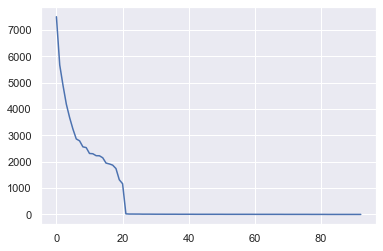

In [31]:
scaff_sizes = df.groupby("ch")["pos"].count()
sorted_scaffs = sorted([(size,scaff) for scaff,size in zip(scaff_sizes.index,scaff_sizes.tolist())],reverse=True)
plt.plot([size for size, scaff in sorted_scaffs])
scaff2idx = {scaff:idx+1 for idx,(count,scaff) in enumerate(sorted_scaffs)}

As you can see, around half of our chromosomes contain only one snp

In [32]:
df["ch_num"] = df["ch"].apply(lambda x: scaff2idx[x])


In [33]:
df = df.sort_values(by=["ch_num"]).reset_index()

In [34]:
df["idx"] = df.index.values
df.head()

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4


In [35]:
for col in ["ph_mean", "ph_var", "temp_mean","temp_var", "ph_freq"]:
    df["log_"+col] = np.log10(df[col])
df.head()

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0,-0.767563,-1.245453,-1.085916,-0.998742,-1.053057
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1,-1.478653,-0.954403,-1.490045,-1.086854,-1.169148
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2,-1.525318,-1.584392,-1.627180,-1.504844,-1.484153
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3,-1.576115,-1.477399,-1.583926,-1.282072,-1.165255
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4,-0.010008,-1.446348,-0.662261,-1.146436,-0.834993


#### Tada! After these transformations we can plot our beautiful Manhetten plots!

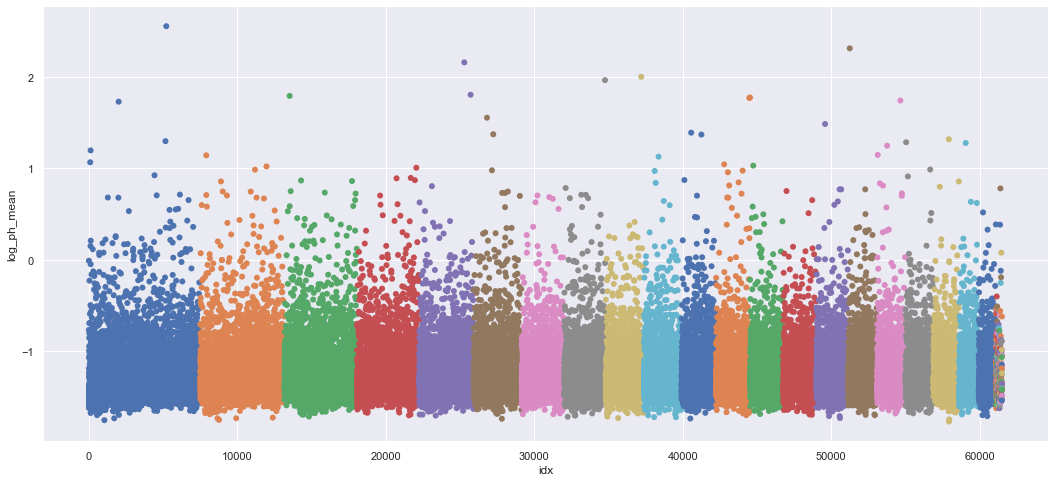

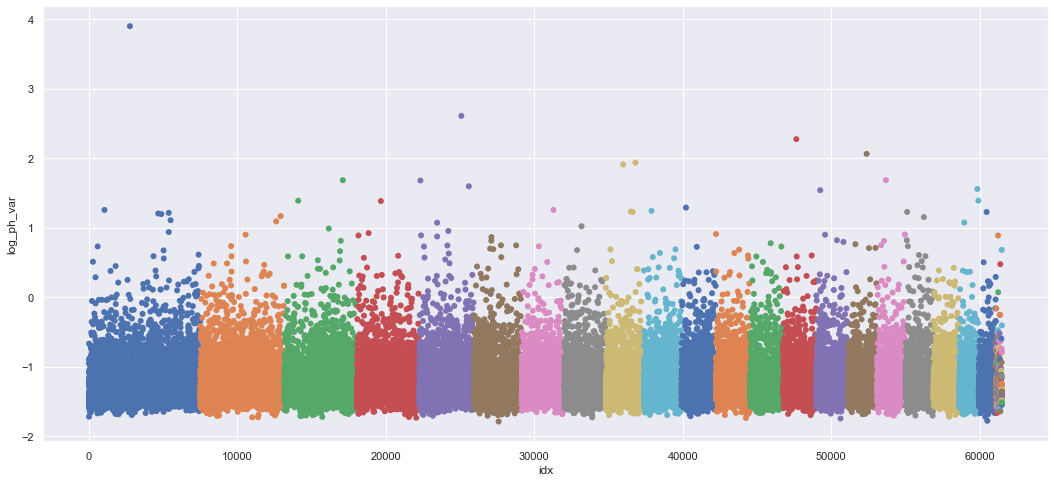

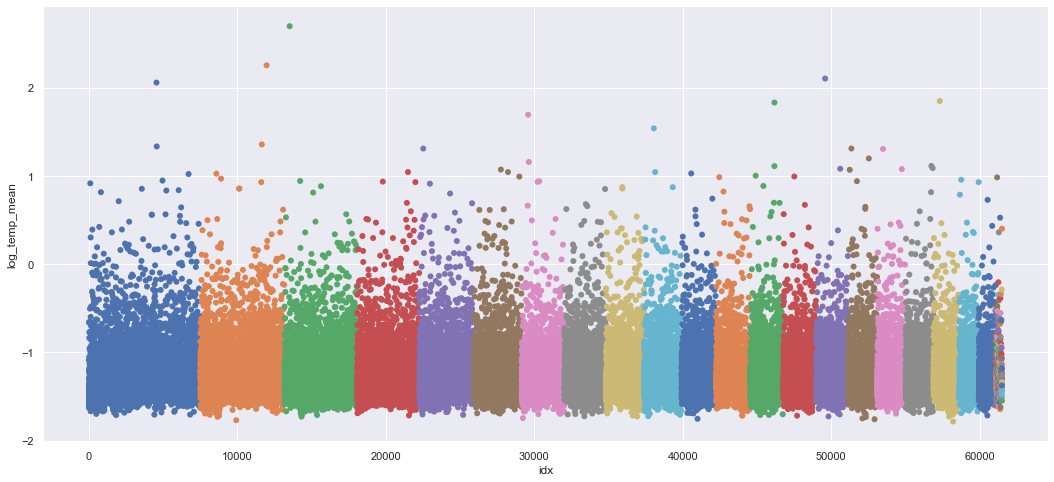

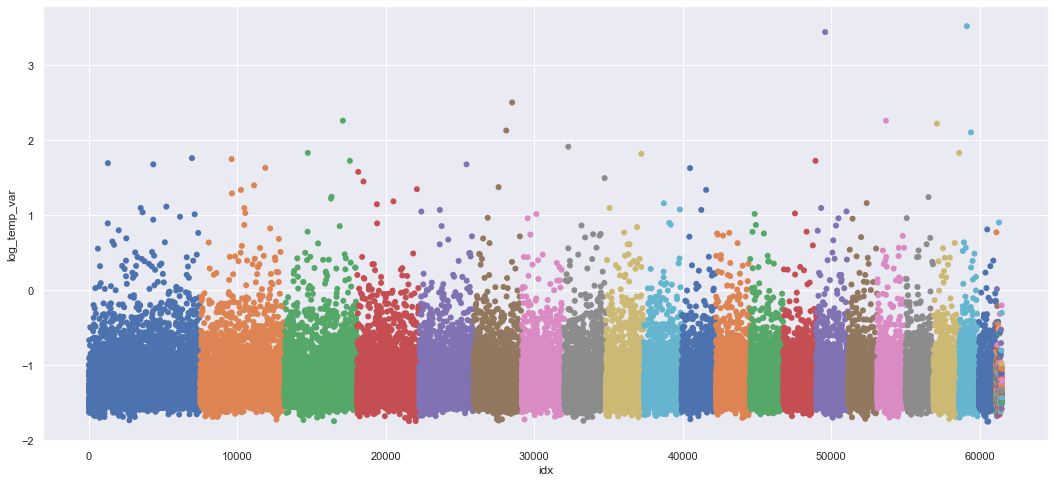

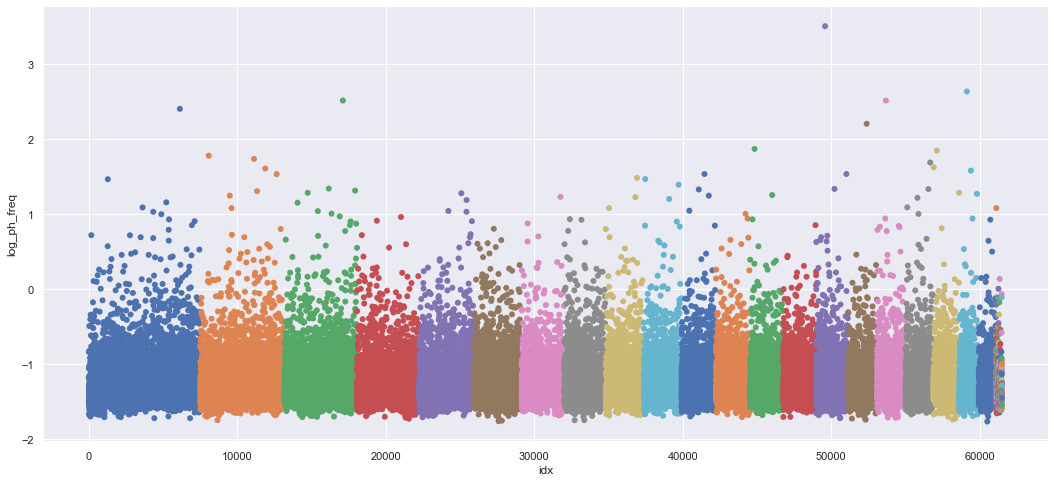

In [36]:
for col in ["ph_mean","ph_var", "temp_mean", "temp_var", "ph_freq"]:
    plt.figure(figsize=(18,8))
    sns.scatterplot(data=df, 
                    x="idx", 
                    y="log_"+col,
                    hue="ch_num",
                    legend=False,
                    palette="deep",
                    linewidth=0)
    plt.show()

### Now let's import and play with that interaction network from String-db!

In [37]:
genes_found = [gene for gene in df.gene.values if gene != '-']
print(len(genes_found))
print(genes_found[:10])

33399
['LOC100888473', 'LOC582475', 'LOC764414', 'LOC764414', 'LOC579746', 'LOC579746', 'LOC578743', 'LOC576136', 'LOC580797', 'LOC580797']


#### Since the interaction network uses the old kind of labeling of genes (starting with SPU), we first have to import the converstion chart provided on the String-db website.

In [38]:
with open("7668.protein.info.v11.0.txt") as f:
    mapping = list(map(lambda x: x.strip().split("\t")[:2],f.readlines()))
    print(mapping[0])
    mapping = {key:val for key,val in mapping[1:]}

['protein_external_id', 'preferred_name']


#### As you can see below, there are much more spu! this is because the new assembly is pretty new! We'll search with LOC but we'll also consider SPUs without a corresponding LOC to be a real node in our network.

In [39]:
spus = [val for val in mapping.values() if "SPU" in val]
locs = [val for val in mapping.values() if "LOC" in val]
"SPUS",len(spus),"LOCS",len(locs),"SUM",len(spus)+len(locs),"TOT",len(mapping)

('SPUS', 19270, 'LOCS', 8820, 'SUM', 28090, 'TOT', 28835)

#### New let's import the network. Combined score /1000 = probability that the edge exists in our network. 

In [40]:
from hashlib import md5
def get_md5(file):
    return md5(open(file,'rb').read()).hexdigest()
ver = get_md5("7668.protein.links.v11.0_raw.txt")
ver

'ec90411db6cadc9589a0f5106bf765bd'

In [41]:
assert get_md5("7668.protein.links.v11.0_raw.txt") == 'ec90411db6cadc9589a0f5106bf765bd', f"File has changed!"

In [42]:
with open("7668.protein.links.v11.0_raw.txt") as f:
    links = list(map(lambda x: x.strip().split(" "), f.readlines()))
    print(links[0])
    links = links[1:]

['protein1', 'protein2', 'combined_score']


In [43]:
links[:10]

[['7668.SPU_000001-tr', '7668.SPU_022560-tr', '205'],
 ['7668.SPU_000001-tr', '7668.SPU_015276-tr', '281'],
 ['7668.SPU_000001-tr', '7668.SPU_001369-tr', '196'],
 ['7668.SPU_000001-tr', '7668.SPU_020052-tr', '196'],
 ['7668.SPU_000001-tr', '7668.SPU_005280-tr', '196'],
 ['7668.SPU_000001-tr', '7668.SPU_012893-tr', '196'],
 ['7668.SPU_000001-tr', '7668.SPU_021496-tr', '196'],
 ['7668.SPU_000002-tr', '7668.SPU_000138-tr', '165'],
 ['7668.SPU_000002-tr', '7668.SPU_020803-tr', '337'],
 ['7668.SPU_000002-tr', '7668.SPU_017511-tr', '158']]

In [44]:
clean_links = [( mapping[_from], mapping[_to], float(conf)/1000.) for _from, _to, conf in links ]

In [45]:
clean_links[:5],links[:5]

([('SPU_000001-tr', 'LOC577894', 0.205),
  ('SPU_000001-tr', 'LOC584839', 0.281),
  ('SPU_000001-tr', 'SPU_001369-tr', 0.196),
  ('SPU_000001-tr', 'SPU_020052-tr', 0.196),
  ('SPU_000001-tr', 'LOC577982', 0.196)],
 [['7668.SPU_000001-tr', '7668.SPU_022560-tr', '205'],
  ['7668.SPU_000001-tr', '7668.SPU_015276-tr', '281'],
  ['7668.SPU_000001-tr', '7668.SPU_001369-tr', '196'],
  ['7668.SPU_000001-tr', '7668.SPU_020052-tr', '196'],
  ['7668.SPU_000001-tr', '7668.SPU_005280-tr', '196']])

In [46]:
confs = np.array([int(conf) for _,_,conf in links])
confs = np.sort(confs)/1000
confs[:10]

array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

<AxesSubplot:ylabel='Density'>

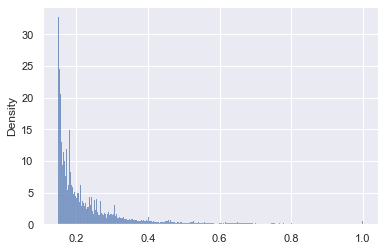

In [47]:
sns.histplot(confs,stat="density")

This figure shows that most of the links have a low confidence. Should we impose a threshold of confidence below which we discard edges? What should that threshold be? Let's experiment!

In [48]:
thresh = .98

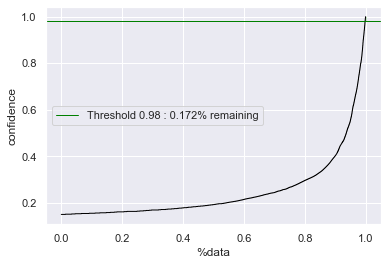

In [49]:

xs = np.linspace(0,1,len(confs))
plt.plot(xs,confs,
         lw=1,
         color="black")
plt.xlabel("%data")
plt.ylabel("confidence")
plt.axhline(thresh,
            label=f"Threshold {thresh} : {len(confs[confs > thresh])/len(confs)*100:.3f}% remaining",
            lw=1,
            color="green")
plt.fill_between(xs, confs, thresh, 
                 where=confs > thresh,
                 alpha=.2,
                 color="green")
plt.legend()

#### With this threshold, we would only keep a very small proportion of our network... and we would discard a lot of valuable information! Not good.

In [49]:
adj = [(_from, _to) for _from, _to, conf in clean_links if conf > thresh]

In [50]:
adj[:10], f"{len(adj)/len(links)*100:.2f}%"

([('SPU_000010-tr', 'LOC577358'),
  ('SPU_000021-tr', 'SPU_010311-tr'),
  ('LOC579751', 'LOC587430'),
  ('LOC579751', 'LOC576006'),
  ('LOC579751', 'LOC591328'),
  ('LOC579751', 'LOC373259'),
  ('LOC579751', 'LOC580950'),
  ('LOC579751', 'LOC579085'),
  ('LOC579751', 'LOC548622'),
  ('LOC579751', 'SPU_006944-tr')],
 '0.17%')

In [51]:


def to_adjlist(adj):
    adj_list = defaultdict(list)
    for _from,_to in adj:
        adj_list[_from].append(_to)

    adj_list = dict(adj_list)
    return adj_list

In [52]:
adj_list = to_adjlist(adj) #reduced network based on threshold

In [53]:
full_adj_list = to_adjlist([(mapping[_from], mapping[_to]) for _from, _to, conf in links]) #full network transformed to adj list format

In [55]:
f"The pruning of edges has preserved {len(adj_list)/len(full_adj_list)*100:.2f}% of our network"

'The pruning of edges has preserved 7.03% of our network'

Average degree 8.440764331210191


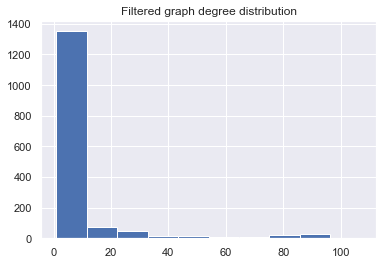

In [56]:
out_edges = np.array([len(out) for node,out in adj_list.items()])
plt.hist(out_edges)
plt.title("Filtered graph degree distribution")
print("Average degree", out_edges.mean())

Average degree 344.5031790095818


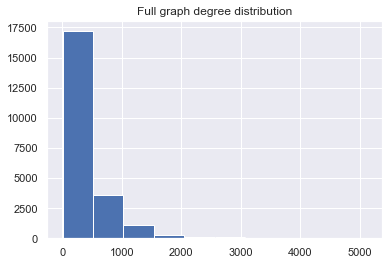

In [57]:
out_edges = np.array([len(out) for node,out in full_adj_list.items()])
plt.hist(out_edges)
plt.title("Full graph degree distribution")
print("Average degree", out_edges.mean())

#### What about different thresholds? Do we always get a power-low distribution? Very interesting!

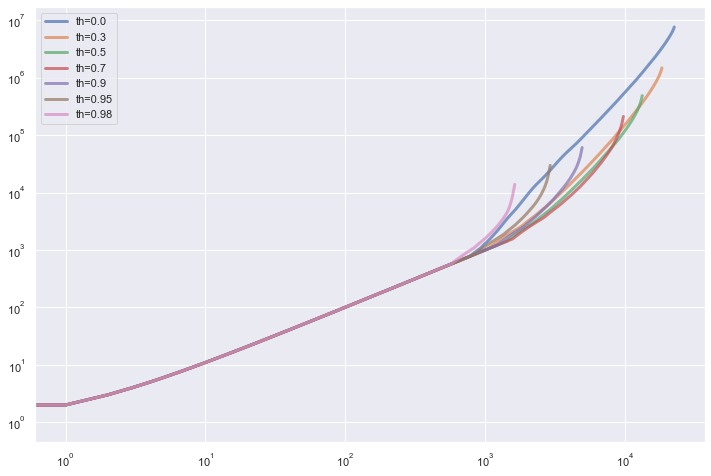

In [58]:
plt.figure(figsize=(12,8))
for th in [.0,.3,.5,.7,.9,.95,.98]:
    zipf = [len(out) for node,out in to_adjlist([(_from, _to) for _from, _to, conf in clean_links 
                                                          if conf >= th]).items()]
    plt.loglog(np.cumsum(np.sort(zipf)),label=f"th={th}",alpha=.7,lw=3)
plt.legend()
plt.show()

#### What about the degree distribution of our found genes? It is similar!

In [59]:
neighs = [len(adj_list[gene]) for gene in genes_found if gene in adj_list]
len(neighs),f"{len(neighs)/len(genes_found)*100:.2f}%"

(808, '2.42%')

<AxesSubplot:ylabel='Density'>

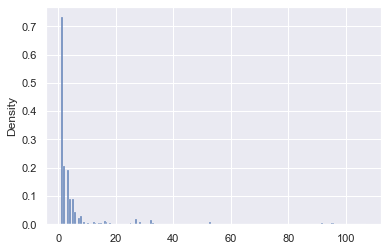

In [60]:
sns.histplot(neighs,stat="density")

In [54]:
neighs = [len(full_adj_list[gene]) for gene in genes_found if gene in full_adj_list]
len(neighs),f"{len(neighs)/len(genes_found)*100:.2f}%"

(11026, '33.01%')

[Text(0.5, 0, 'Number of neighbors')]

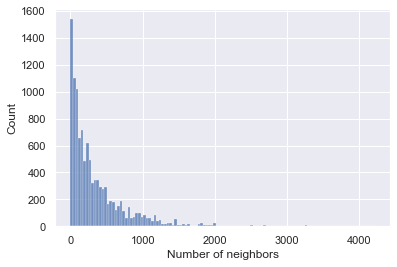

In [68]:
ax=sns.histplot(neighs) #unweighted, full network data
ax.set(xlabel='Number of neighbors')

Text(0, 0.5, 'Frequency')

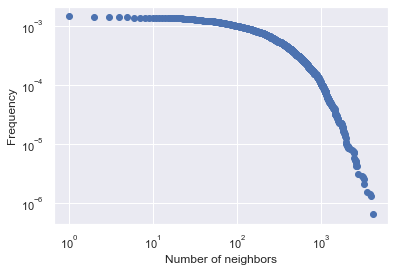

In [62]:
xs,ys = list(zip(*sorted(Counter(neighs).most_common(),reverse=True)))
ys = np.array(ys)/len(links)
plt.loglog(xs,np.cumsum(ys),"o",label="full graph")
#plt.legend()
#plt.title("Degree centrality CCDF")
plt.xlabel("Number of neighbors")
plt.ylabel("Frequency")
#plt.savefig("centr.png")

In [63]:
#max_neighs, max_gene =  max([(len(adj_list[gene]),gene) for gene in genes_found if gene in adj_list])

### Conclusion: thresholding doesn't seem to be a good idea. Instead, let's add together the probabilities when calculating number of neighbors!

In [69]:
df

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0,-0.767563,-1.245453,-1.085916,-0.998742,-1.053057
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1,-1.478653,-0.954403,-1.490045,-1.086854,-1.169148
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2,-1.525318,-1.584392,-1.627180,-1.504844,-1.484153
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3,-1.576115,-1.477399,-1.583926,-1.282072,-1.165255
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4,-0.010008,-1.446348,-0.662261,-1.146436,-0.834993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61501,42046,NW_022145489.1,14494,LOC594069,0.057185,0.032531,0.045991,0.101380,0.035645,89,61501,-1.242718,-1.487703,-1.337327,-0.994048,-1.448001
61502,18585,NW_022145476.1,15985,-,0.039209,0.391570,0.036834,0.036179,0.052990,90,61502,-1.406614,-0.407191,-1.433751,-1.441543,-1.275806
61503,50357,NW_022145465.1,2097,LOC577919,0.028931,0.028120,0.042209,0.030969,0.035798,91,61503,-1.538637,-1.550985,-1.374595,-1.509073,-1.446141
61504,1,NW_022145457.1,35106,-,0.239770,0.055549,2.518000,0.089243,0.101080,92,61504,-0.620205,-1.255324,0.401056,-1.049426,-0.995335


#### Question: is there a correlation between bayenv factor and degree?

In [70]:
degrees = {gene : len(full_adj_list[gene]) for gene in genes_found if gene in full_adj_list}
df["neighs"] = df["gene"].apply(lambda x: degrees[x] if x in degrees else 0)

In [71]:
df[df["neighs"]!=0][:10]

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391
35,48460,NW_022145612.1,46391491,LOC582245,0.040318,0.080794,0.041505,0.075778,0.151530,1,35,-1.394501,-1.092621,-1.381900,-1.120457,-0.819501,39
36,48461,NW_022145612.1,46417102,LOC584806,0.038857,0.036119,0.033750,0.028694,0.042764,1,36,-1.410531,-1.442264,-1.471726,-1.542209,-1.368922,39
37,48462,NW_022145612.1,46421400,LOC584806,0.027584,0.039046,0.041686,0.034710,0.030440,1,37,-1.559343,-1.408423,-1.380010,-1.459545,-1.516555,39
38,48463,NW_022145612.1,46439503,LOC580261,0.050422,0.024361,0.040984,0.032968,0.029926,1,38,-1.297380,-1.613305,-1.387386,-1.481907,-1.523951,39
45,48470,NW_022145612.1,47112660,LOC582064,0.039171,0.046284,0.039436,0.034324,0.032035,1,45,-1.407035,-1.334569,-1.404107,-1.464402,-1.494375,39


In [72]:
cols = ["ph_mean", "ph_var", "temp_mean","temp_var", "ph_freq"]
for col in cols:
    corr = df["neighs"].corr(df[col])
    print(f"Correlation between #neighs and {col:>9} = {corr:+.4f}")

Correlation between #neighs and   ph_mean = +0.0086
Correlation between #neighs and    ph_var = -0.0011
Correlation between #neighs and temp_mean = -0.0001
Correlation between #neighs and  temp_var = -0.0019
Correlation between #neighs and   ph_freq = -0.0018


In [73]:
red_df = df.copy(deep=True)
red_df = red_df[red_df["neighs"]!=0]
red_df["log_"+"neighs"] = np.log10(red_df["neighs"])
red_df.head()

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,log_neighs
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,2.342423
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,2.342423
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,2.342423
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,2.214844
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,2.592177


In [74]:
cols = ["log_ph_mean", "log_ph_var", "log_temp_mean","log_temp_var", "log_ph_freq"]
for col in cols:
    corr = red_df["log_neighs"].corr(red_df[col])
    print(f"Correlation between #neighs and {col:>9} = {corr:+.4f}")

Correlation between #neighs and log_ph_mean = +0.0006
Correlation between #neighs and log_ph_var = +0.0035
Correlation between #neighs and log_temp_mean = +0.0137
Correlation between #neighs and log_temp_var = -0.0031
Correlation between #neighs and log_ph_freq = -0.0085


#### The above was calculated based on the whole, unfiltered network. Let's now calculate the degree that takes into account the probailities!

In [75]:
def weighted_graph():
    adj = [(_from, _to, conf) for _from, _to, conf in clean_links]
    adj_list = defaultdict(list)
    for _from,_to, conf in adj:
        adj_list[_from].append((_to,conf))

    adj_list = dict(adj_list)
    return adj_list

w_adj_list = weighted_graph()

In [76]:
w_degrees = {gene : np.sum([conf for node,conf in w_adj_list[gene]]) for gene in genes_found if gene in adj_list}
df["w_neighs"] = df["gene"].apply(lambda x: w_degrees[x] if x in w_degrees else 0)

In [77]:
df[df["w_neighs"]!=0]

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs
70,48562,NW_022145612.1,52109544,LOC580083,0.097494,0.035651,0.312840,0.058930,0.034464,1,70,-1.011022,-1.447928,-0.504678,-1.229664,-1.462634,1770,501.318
86,48578,NW_022145612.1,54272551,LOC575335,0.042506,0.037809,0.048777,0.066163,0.072904,1,86,-1.371550,-1.422405,-1.311785,-1.179385,-1.137249,1727,475.477
397,48590,NW_022145612.1,55061056,LOC578003,0.045652,0.038470,0.038843,0.039983,0.035642,1,397,-1.340540,-1.414878,-1.410687,-1.398125,-1.448038,222,60.442
424,48649,NW_022145612.1,59075440,LOC579900,0.035870,0.038853,0.036327,0.043442,0.038272,1,424,-1.445269,-1.410575,-1.439770,-1.362090,-1.417119,552,170.594
460,48619,NW_022145612.1,55905272,LOC578192,0.208180,0.044436,1.011800,0.154700,0.049041,1,460,-0.681561,-1.352265,0.005095,-0.810510,-1.309441,1532,626.107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60833,24166,NW_022145606.1,7070487,LOC581147,0.070863,0.064660,0.056782,0.073372,0.051929,21,60833,-1.149580,-1.189364,-1.245789,-1.134470,-1.284590,725,193.283
61011,55187,NW_022145606.1,7067647,LOC581147,0.054955,0.021462,0.046966,0.025183,0.026456,21,61011,-1.259993,-1.668330,-1.328216,-1.598893,-1.577476,725,193.283
61045,55209,NW_022145606.1,9571794,LOC578859,0.066382,0.066099,0.079359,0.077702,0.142340,21,61045,-1.177950,-1.179805,-1.100404,-1.109568,-0.846673,1908,520.877
61418,31000,NW_022145527.1,594100,LOC593816,0.043927,0.042534,0.042703,0.105220,0.056643,59,61418,-1.357268,-1.371264,-1.369542,-0.977902,-1.246854,326,100.323


In [78]:
cols = ["ph_mean", "ph_var","temp_mean","temp_var", "ph_freq"]
for col in cols:
    corr = df["w_neighs"].corr(df[col])
    print(f"Correlation between #w_neighs and {col:>9} = {corr:+.4f}")

Correlation between #w_neighs and   ph_mean = -0.0016
Correlation between #w_neighs and    ph_var = -0.0005
Correlation between #w_neighs and temp_mean = -0.0004
Correlation between #w_neighs and  temp_var = -0.0008
Correlation between #w_neighs and   ph_freq = -0.0008


In [79]:
red_df = df.copy(deep=True)
red_df = red_df[red_df["w_neighs"]!=0]
red_df["log_"+"w_neighs"] = np.log10(red_df["w_neighs"])
red_df.head()

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,log_w_neighs
70,48562,NW_022145612.1,52109544,LOC580083,0.097494,0.035651,0.312840,0.058930,0.034464,1,70,-1.011022,-1.447928,-0.504678,-1.229664,-1.462634,1770,501.318,2.700113
86,48578,NW_022145612.1,54272551,LOC575335,0.042506,0.037809,0.048777,0.066163,0.072904,1,86,-1.371550,-1.422405,-1.311785,-1.179385,-1.137249,1727,475.477,2.677130
397,48590,NW_022145612.1,55061056,LOC578003,0.045652,0.038470,0.038843,0.039983,0.035642,1,397,-1.340540,-1.414878,-1.410687,-1.398125,-1.448038,222,60.442,1.781339
424,48649,NW_022145612.1,59075440,LOC579900,0.035870,0.038853,0.036327,0.043442,0.038272,1,424,-1.445269,-1.410575,-1.439770,-1.362090,-1.417119,552,170.594,2.231964
460,48619,NW_022145612.1,55905272,LOC578192,0.208180,0.044436,1.011800,0.154700,0.049041,1,460,-0.681561,-1.352265,0.005095,-0.810510,-1.309441,1532,626.107,2.796649


In [80]:
cols = ["log_ph_mean", "log_ph_var","log_temp_mean","log_temp_var", "log_ph_freq"]
for col in cols:
    corr = red_df["log_w_neighs"].corr(red_df[col])
    print(f"Correlation between #w_neighs and {col:>9} = {corr:+.4f}")

Correlation between #w_neighs and log_ph_mean = -0.0223
Correlation between #w_neighs and log_ph_var = +0.0110
Correlation between #w_neighs and log_temp_mean = -0.0406
Correlation between #w_neighs and log_temp_var = -0.0167
Correlation between #w_neighs and log_ph_freq = -0.0196


<AxesSubplot:xlabel='log_ph_freq', ylabel='log_w_neighs'>

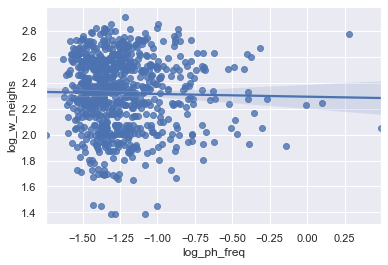

In [81]:
sns.regplot(data=red_df, x="log_ph_freq", y="log_w_neighs")

In [82]:
x = red_df["log_ph_freq"].to_numpy()
x = x.reshape((-1, 1))
y = red_df["log_w_neighs"].to_numpy()

In [83]:
reg = LinearRegression().fit(x,y)

In [84]:
reg.score(x, y) #R squared

0.000384224511930209

In [85]:
reg.coef_ #slope

array([-0.02085295])

In [86]:
reg.intercept_

2.291473056317615

### Sanity check for our weighting approach

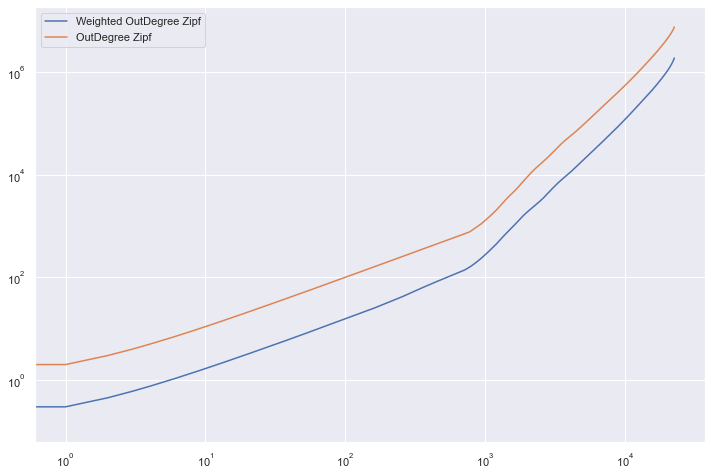

In [87]:
plt.figure(figsize=(12,8))
full_w_degrees = {gene : np.sum([conf for node,conf in neighs]) for gene, neighs in w_adj_list.items()}
full_w_neighs = np.array(list(full_w_degrees.values()))
plt.loglog(np.cumsum(np.sort(full_w_neighs)),label="Weighted OutDegree Zipf")
plt.loglog(np.cumsum(np.sort([len(out) for node,out in full_adj_list.items()])),label="OutDegree Zipf")
plt.legend()

# Now let's calculate centrality

In [83]:
import networkx as nx

In [84]:
clean_links[0]

('SPU_000001-tr', 'LOC577894', 0.205)

In [85]:
for key in w_adj_list:
    w_adj_list[key]={sub[0]:{"weight":sub[1]} for sub in w_adj_list[key]} 

In [86]:
temp = {key:val for key,val in list(w_adj_list.items())[:20]}


In [87]:
G = nx.from_dict_of_dicts(temp, create_using=nx.Graph)
#G.edges.data('weight')

In [89]:
cent = nx.betweenness_centrality(G)

In [90]:
genes = set(df.gene.unique())


In [91]:
interesting_links = [(_from, _to, conf) for _from, _to, conf in clean_links if _from in genes or _to in genes]

In [92]:
w_links = [(_from, _to, conf) for _from, _to, conf in interesting_links if conf > .95 ]
len(w_links)

8482

In [93]:
G = nx.Graph()
G.add_weighted_edges_from(w_links)

In [94]:
xs,ys = list(zip(*sorted(Counter(nx.degree_centrality(G).values()).most_common())))
ys = np.array(ys)/len(w_links)

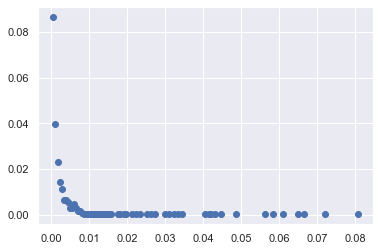

In [95]:
plt.scatter(xs,ys)

In [96]:
full_G = nx.Graph()
full_G.add_weighted_edges_from(clean_links)

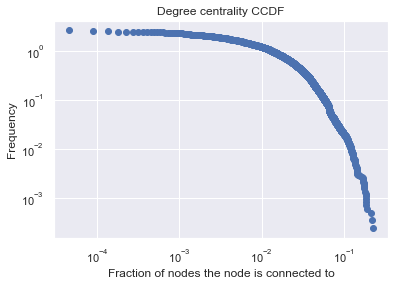

In [97]:
#xs,ys = list(zip(*sorted(Counter(nx.degree_centrality(G).values()).most_common(),reverse=True)))
#ys = np.array(ys)/len(w_links)
#plt.loglog(xs,np.cumsum(ys),"o",label="genes of interest")
xs,ys = list(zip(*sorted(Counter(nx.degree_centrality(full_G).values()).most_common(),reverse=True)))
ys = np.array(ys)/len(w_links)
plt.loglog(xs,np.cumsum(ys),"o",label="full graph")
#plt.legend()
plt.title("Degree centrality CCDF")
plt.xlabel("Fraction of nodes the node is connected to")
plt.ylabel("Frequency")
plt.savefig("centr.png")

In [98]:
centr=nx.degree_centrality(full_G)

In [99]:
df

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0,-0.767563,-1.245453,-1.085916,-0.998742,-1.053057,0,0.0
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1,-1.478653,-0.954403,-1.490045,-1.086854,-1.169148,0,0.0
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2,-1.525318,-1.584392,-1.627180,-1.504844,-1.484153,0,0.0
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3,-1.576115,-1.477399,-1.583926,-1.282072,-1.165255,0,0.0
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4,-0.010008,-1.446348,-0.662261,-1.146436,-0.834993,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61501,42046,NW_022145489.1,14494,LOC594069,0.057185,0.032531,0.045991,0.101380,0.035645,89,61501,-1.242718,-1.487703,-1.337327,-0.994048,-1.448001,0,0.0
61502,18585,NW_022145476.1,15985,-,0.039209,0.391570,0.036834,0.036179,0.052990,90,61502,-1.406614,-0.407191,-1.433751,-1.441543,-1.275806,0,0.0
61503,50357,NW_022145465.1,2097,LOC577919,0.028931,0.028120,0.042209,0.030969,0.035798,91,61503,-1.538637,-1.550985,-1.374595,-1.509073,-1.446141,833,0.0
61504,1,NW_022145457.1,35106,-,0.239770,0.055549,2.518000,0.089243,0.101080,92,61504,-0.620205,-1.255324,0.401056,-1.049426,-0.995335,0,0.0


In [100]:
t=df.gene.isin(centr.keys())

In [101]:
filtered=df[t]

In [102]:
filtered

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61427,50429,NW_022145580.1,898773,LOC590251,0.032774,0.034958,0.032300,0.034502,0.036557,61,61427,-1.484471,-1.456453,-1.490797,-1.462156,-1.437029,129,0.0
61444,50398,NW_022145549.1,180393,LOC594315,0.037482,0.065480,0.042894,0.081686,0.041521,65,61444,-1.426177,-1.183891,-1.367603,-1.087852,-1.381732,566,0.0
61471,18596,NW_022145520.1,2249028,LOC585134,0.046881,0.041787,0.062091,0.052067,0.060263,73,61471,-1.329003,-1.378959,-1.206971,-1.283437,-1.219949,383,0.0
61500,11090,NW_022145518.1,223420,LOC764237,0.128910,0.071184,0.055876,0.045872,0.042086,88,61500,-0.889713,-1.147618,-1.252775,-1.338452,-1.375862,430,0.0


In [103]:
df["centr"] = filtered["gene"].apply(lambda x: centr[x])


In [104]:
df[df.centr.notnull()]

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0,0.009851
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0,0.009851
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0,0.009851
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0,0.007343
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0,0.017508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61427,50429,NW_022145580.1,898773,LOC590251,0.032774,0.034958,0.032300,0.034502,0.036557,61,61427,-1.484471,-1.456453,-1.490797,-1.462156,-1.437029,129,0.0,0.005776
61444,50398,NW_022145549.1,180393,LOC594315,0.037482,0.065480,0.042894,0.081686,0.041521,65,61444,-1.426177,-1.183891,-1.367603,-1.087852,-1.381732,566,0.0,0.025344
61471,18596,NW_022145520.1,2249028,LOC585134,0.046881,0.041787,0.062091,0.052067,0.060263,73,61471,-1.329003,-1.378959,-1.206971,-1.283437,-1.219949,383,0.0,0.017150
61500,11090,NW_022145518.1,223420,LOC764237,0.128910,0.071184,0.055876,0.045872,0.042086,88,61500,-0.889713,-1.147618,-1.252775,-1.338452,-1.375862,430,0.0,0.019254


In [105]:
red_df = df.copy(deep=True)
red_df = red_df[red_df.centr.notnull()]
red_df["log_"+"centr"] = np.log10(red_df["centr"])
red_df.head()

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr,log_centr
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0,0.009851,-2.006524
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0,0.009851,-2.006524
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0,0.009851,-2.006524
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0,0.007343,-2.134103
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0,0.017508,-1.756770


In [106]:
cols = ["log_ph_mean", "log_ph_var","log_temp_mean","log_temp_var", "log_ph_freq"]
for col in cols:
    corr = red_df["log_centr"].corr(red_df[col])
    print(f"Correlation between #w_neighs and {col:>9} = {corr:+.4f}")

Correlation between #w_neighs and log_ph_mean = +0.0006
Correlation between #w_neighs and log_ph_var = +0.0035
Correlation between #w_neighs and log_temp_mean = +0.0137
Correlation between #w_neighs and log_temp_var = -0.0031
Correlation between #w_neighs and log_ph_freq = -0.0085


In [107]:
cols = ["ph_mean", "ph_var","temp_mean","temp_var", "ph_freq"]
for col in cols:
    corr = red_df["centr"].corr(red_df[col])
    print(f"Correlation between #w_neighs and {col:>9} = {corr:+.4f}")

Correlation between #w_neighs and   ph_mean = +0.0100
Correlation between #w_neighs and    ph_var = +0.0027
Correlation between #w_neighs and temp_mean = -0.0016
Correlation between #w_neighs and  temp_var = +0.0054
Correlation between #w_neighs and   ph_freq = +0.0021


# Let's look at expression levels now

In [88]:
with open("CombinedCounts_NotNormalized.txt","r") as f:
    exps = f.readlines()

In [89]:
exp_genes = ["7668." + tmp.split("\t")[0]  + "-tr" for tmp in exps[1:]]

In [90]:
def calc_exp(l):
    t=[int(i) for i in l.split("\t")[1:-1]] 
    return(sum(t))

In [91]:
exp_levels =[calc_exp(tmp) for tmp in exps[1:]]

In [137]:
max(sorted(exp_levels)[:27000])

33988

In [138]:
ex=sorted(exp_levels)[:27000]

[Text(0.5, 0, 'Level of expression')]

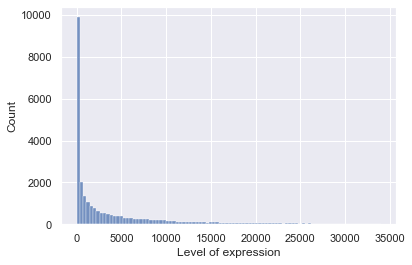

In [139]:
ax=sns.histplot(ex) #only showing first 27000 datapoints, otherwise wouldn't be visible
ax.set(xlabel='Level of expression')

Text(0, 0.5, 'Frequency')

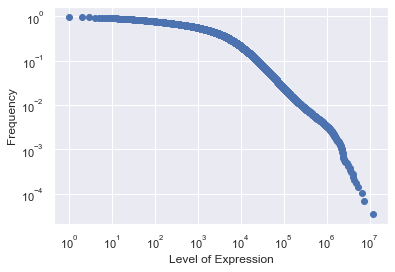

In [141]:
xs,ys = list(zip(*sorted(Counter(exp_levels).most_common(),reverse=True)))
ys = np.array(ys)/len(exp_levels)
plt.loglog(xs,np.cumsum(ys),"o",label="genes of interest")
#plt.title("Level of expression CCDF")
plt.xlabel("Level of Expression")
plt.ylabel("Frequency")
#plt.savefig("exp_level.png")

In [113]:
res_exp = {exp_genes[i]: exp_levels[i] for i in range(len(exp_genes))}

In [114]:
red_genes = {mapping[x]:val for x,val in res_exp.items() if x in mapping}

In [115]:
df

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0,-0.767563,-1.245453,-1.085916,-0.998742,-1.053057,0,0.0,NaN
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1,-1.478653,-0.954403,-1.490045,-1.086854,-1.169148,0,0.0,NaN
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2,-1.525318,-1.584392,-1.627180,-1.504844,-1.484153,0,0.0,NaN
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3,-1.576115,-1.477399,-1.583926,-1.282072,-1.165255,0,0.0,NaN
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4,-0.010008,-1.446348,-0.662261,-1.146436,-0.834993,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61501,42046,NW_022145489.1,14494,LOC594069,0.057185,0.032531,0.045991,0.101380,0.035645,89,61501,-1.242718,-1.487703,-1.337327,-0.994048,-1.448001,0,0.0,NaN
61502,18585,NW_022145476.1,15985,-,0.039209,0.391570,0.036834,0.036179,0.052990,90,61502,-1.406614,-0.407191,-1.433751,-1.441543,-1.275806,0,0.0,NaN
61503,50357,NW_022145465.1,2097,LOC577919,0.028931,0.028120,0.042209,0.030969,0.035798,91,61503,-1.538637,-1.550985,-1.374595,-1.509073,-1.446141,833,0.0,0.037299
61504,1,NW_022145457.1,35106,-,0.239770,0.055549,2.518000,0.089243,0.101080,92,61504,-0.620205,-1.255324,0.401056,-1.049426,-0.995335,0,0.0,NaN


In [116]:
t=df.gene.isin(red_genes.keys())
filt = df[t]

In [117]:
filt

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0,0.009851
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0,0.009851
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0,0.009851
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0,0.007343
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0,0.017508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61427,50429,NW_022145580.1,898773,LOC590251,0.032774,0.034958,0.032300,0.034502,0.036557,61,61427,-1.484471,-1.456453,-1.490797,-1.462156,-1.437029,129,0.0,0.005776
61444,50398,NW_022145549.1,180393,LOC594315,0.037482,0.065480,0.042894,0.081686,0.041521,65,61444,-1.426177,-1.183891,-1.367603,-1.087852,-1.381732,566,0.0,0.025344
61471,18596,NW_022145520.1,2249028,LOC585134,0.046881,0.041787,0.062091,0.052067,0.060263,73,61471,-1.329003,-1.378959,-1.206971,-1.283437,-1.219949,383,0.0,0.017150
61500,11090,NW_022145518.1,223420,LOC764237,0.128910,0.071184,0.055876,0.045872,0.042086,88,61500,-0.889713,-1.147618,-1.252775,-1.338452,-1.375862,430,0.0,0.019254


In [118]:
df["exp_level"] = filt["gene"].apply(lambda x: red_genes[x])

In [119]:
df[df["exp_level"]>0]

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr,exp_level
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,23,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0,0.009851,22756.0
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,24,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0,0.009851,22756.0
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,25,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0,0.009851,22756.0
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,26,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0,0.007343,75336.0
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,30,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0,0.017508,1475.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61427,50429,NW_022145580.1,898773,LOC590251,0.032774,0.034958,0.032300,0.034502,0.036557,61,61427,-1.484471,-1.456453,-1.490797,-1.462156,-1.437029,129,0.0,0.005776,1755.0
61444,50398,NW_022145549.1,180393,LOC594315,0.037482,0.065480,0.042894,0.081686,0.041521,65,61444,-1.426177,-1.183891,-1.367603,-1.087852,-1.381732,566,0.0,0.025344,82829.0
61471,18596,NW_022145520.1,2249028,LOC585134,0.046881,0.041787,0.062091,0.052067,0.060263,73,61471,-1.329003,-1.378959,-1.206971,-1.283437,-1.219949,383,0.0,0.017150,15705.0
61500,11090,NW_022145518.1,223420,LOC764237,0.128910,0.071184,0.055876,0.045872,0.042086,88,61500,-0.889713,-1.147618,-1.252775,-1.338452,-1.375862,430,0.0,0.019254,8997.0


In [120]:
red_df = df.copy(deep=True)
red_df = red_df[red_df["exp_level"]>0]
red_df["log_"+"exp"] = np.log10(red_df["exp_level"])
red_df

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,...,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr,exp_level,log_exp
23,48514,NW_022145612.1,49402402,LOC580797,0.035573,0.026947,0.035266,0.053585,0.033731,1,...,-1.448880,-1.569490,-1.452644,-1.270957,-1.471971,220,0.0,0.009851,22756.0,4.357096
24,48515,NW_022145612.1,49431419,LOC580797,0.085226,0.029792,0.050153,0.074401,0.039857,1,...,-1.069428,-1.525900,-1.299703,-1.128421,-1.399495,220,0.0,0.009851,22756.0,4.357096
25,48516,NW_022145612.1,49473999,LOC580797,0.029192,0.031796,0.030851,0.030944,0.029464,1,...,-1.534736,-1.497628,-1.510731,-1.509424,-1.530708,220,0.0,0.009851,22756.0,4.357096
26,48517,NW_022145612.1,49493792,LOC580859,0.025019,0.033079,0.027264,0.023108,0.021254,1,...,-1.601730,-1.480448,-1.564410,-1.636238,-1.672559,164,0.0,0.007343,75336.0,4.877003
30,48491,NW_022145612.1,48580410,LOC581981,0.058207,0.123730,0.044884,0.052744,0.054925,1,...,-1.235025,-0.907525,-1.347908,-1.277827,-1.260230,391,0.0,0.017508,1475.0,3.168792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61427,50429,NW_022145580.1,898773,LOC590251,0.032774,0.034958,0.032300,0.034502,0.036557,61,...,-1.484471,-1.456453,-1.490797,-1.462156,-1.437029,129,0.0,0.005776,1755.0,3.244277
61444,50398,NW_022145549.1,180393,LOC594315,0.037482,0.065480,0.042894,0.081686,0.041521,65,...,-1.426177,-1.183891,-1.367603,-1.087852,-1.381732,566,0.0,0.025344,82829.0,4.918182
61471,18596,NW_022145520.1,2249028,LOC585134,0.046881,0.041787,0.062091,0.052067,0.060263,73,...,-1.329003,-1.378959,-1.206971,-1.283437,-1.219949,383,0.0,0.017150,15705.0,4.196038
61500,11090,NW_022145518.1,223420,LOC764237,0.128910,0.071184,0.055876,0.045872,0.042086,88,...,-0.889713,-1.147618,-1.252775,-1.338452,-1.375862,430,0.0,0.019254,8997.0,3.954098


In [121]:
cols = ["log_ph_mean", "log_ph_var","log_temp_mean","log_temp_var", "log_ph_freq"]
for col in cols:
    corr = red_df["log_exp"].corr(red_df[col])
    print(f"Correlation between #w_neighs and {col:>9} = {corr:+.4f}")

Correlation between #w_neighs and log_ph_mean = -0.0195
Correlation between #w_neighs and log_ph_var = -0.0181
Correlation between #w_neighs and log_temp_mean = -0.0161
Correlation between #w_neighs and log_temp_var = -0.0086
Correlation between #w_neighs and log_ph_freq = -0.0060


# Let's make our final variable - number of snps in the gene!

In [122]:
df

,index,ch,pos,gene,ph_mean,ph_var,temp_mean,temp_var,ph_freq,ch_num,idx,log_ph_mean,log_ph_var,log_temp_mean,log_temp_var,log_ph_freq,neighs,w_neighs,centr,exp_level
0,28119,NW_022145612.1,50053666,LOC100888473,0.170780,0.056826,0.082051,0.100290,0.088500,1,0,-0.767563,-1.245453,-1.085916,-0.998742,-1.053057,0,0.0,NaN,NaN
1,48492,NW_022145612.1,48586134,-,0.033216,0.111070,0.032356,0.081874,0.067741,1,1,-1.478653,-0.954403,-1.490045,-1.086854,-1.169148,0,0.0,NaN,NaN
2,48493,NW_022145612.1,48603898,-,0.029832,0.026038,0.023595,0.031272,0.032798,1,2,-1.525318,-1.584392,-1.627180,-1.504844,-1.484153,0,0.0,NaN,NaN
3,48494,NW_022145612.1,48637206,-,0.026539,0.033312,0.026066,0.052231,0.068351,1,3,-1.576115,-1.477399,-1.583926,-1.282072,-1.165255,0,0.0,NaN,NaN
4,48495,NW_022145612.1,48661666,LOC582475,0.977220,0.035781,0.217640,0.071378,0.146220,1,4,-0.010008,-1.446348,-0.662261,-1.146436,-0.834993,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61501,42046,NW_022145489.1,14494,LOC594069,0.057185,0.032531,0.045991,0.101380,0.035645,89,61501,-1.242718,-1.487703,-1.337327,-0.994048,-1.448001,0,0.0,NaN,NaN
61502,18585,NW_022145476.1,15985,-,0.039209,0.391570,0.036834,0.036179,0.052990,90,61502,-1.406614,-0.407191,-1.433751,-1.441543,-1.275806,0,0.0,NaN,NaN
61503,50357,NW_022145465.1,2097,LOC577919,0.028931,0.028120,0.042209,0.030969,0.035798,91,61503,-1.538637,-1.550985,-1.374595,-1.509073,-1.446141,833,0.0,0.037299,230680.0
61504,1,NW_022145457.1,35106,-,0.239770,0.055549,2.518000,0.089243,0.101080,92,61504,-0.620205,-1.255324,0.401056,-1.049426,-0.995335,0,0.0,NaN,NaN


In [123]:
len(df.gene.unique())

9692

In [124]:
n_snps= df.groupby(['gene']).count().ch

In [125]:
n_snps

gene
-               28107
LOC100144872       10
LOC100147806        2
LOC100887834        3
LOC100887841        3
                ...  
LOC765159           1
LOC765161           5
LOC767502           7
LOXL2              14
lox                13
Name: ch, Length: 9692, dtype: int64

In [126]:
new_df = pd.DataFrame(n_snps.reset_index(name = "snp_count"))

In [127]:
new_df[1:]

,gene,snp_count
1,LOC100144872,10
2,LOC100147806,2
3,LOC100887834,3
4,LOC100887841,3
5,LOC100887842,1
...,...,...
9687,LOC765159,1
9688,LOC765161,5
9689,LOC767502,7
9690,LOXL2,14


In [128]:
counted_df = df.merge(new_df[1:], how="outer")

In [131]:
counted_df.to_csv("test_most.csv",index=False)